In [180]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

### Load data from kaggle, check to see if there are any null values

In [167]:
# Dataset obtained from: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

df = pd.read_csv('star_classification.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

### Drop ID tables

In [168]:
df = df.drop(['spec_obj_ID','obj_ID','run_ID', 'rerun_ID', 'field_ID', 'fiber_ID','cam_col'], axis = 1)

### Data distribution of each class

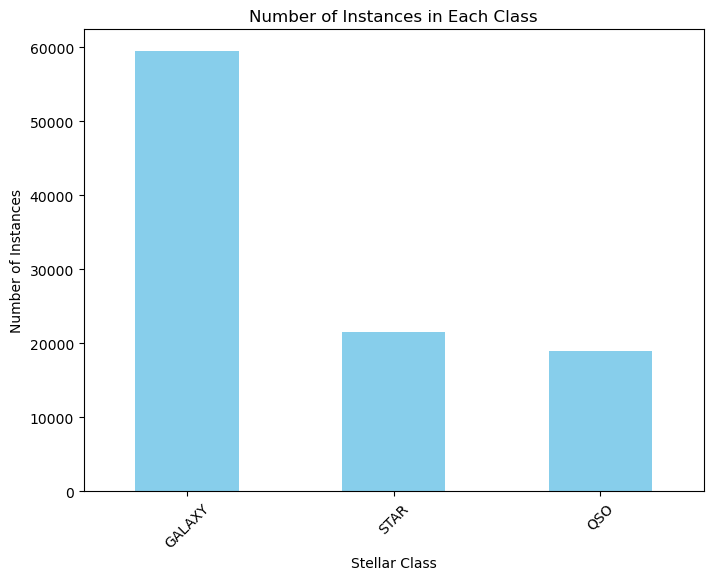

In [169]:
class_counts = df['class'].value_counts()

# Plotting the number of instances in each class
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Instances in Each Class')
plt.xlabel('Stellar Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.show()

In [170]:
column_to_encode = 'class'  

label_encoder = LabelEncoder()

df[column_to_encode + '_encoded'] = label_encoder.fit_transform(df[column_to_encode])

# Get the mapping between original labels and encoded integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Label mapping:")
print(label_mapping)

df.drop(column_to_encode,axis=1, inplace=True)

Label mapping:
{'GALAXY': 0, 'QSO': 1, 'STAR': 2}


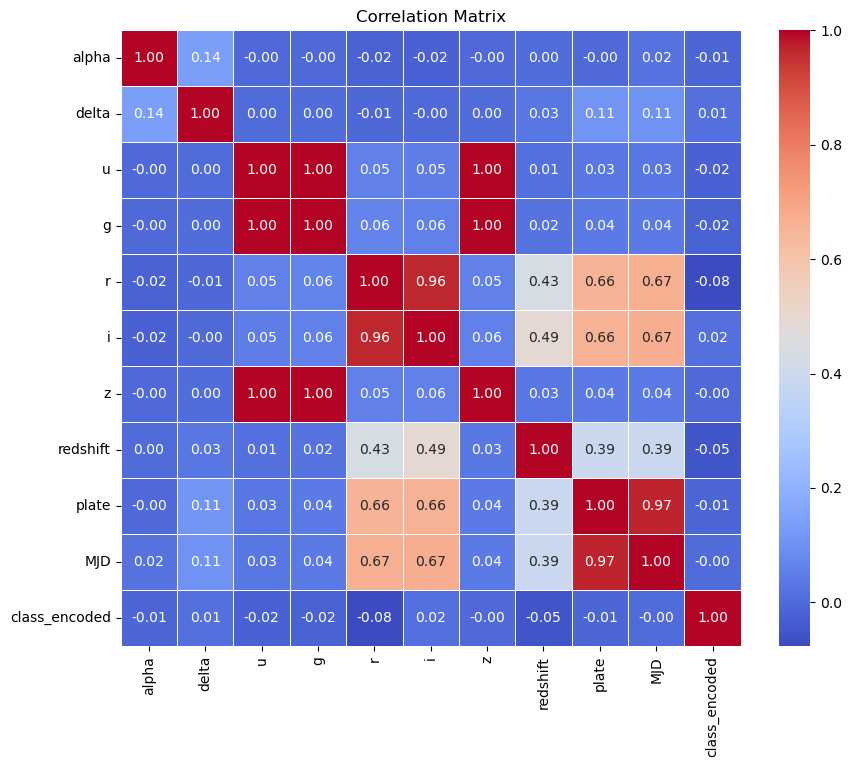

In [171]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set the title and display the plot
plt.title('Correlation Matrix')
plt.show()

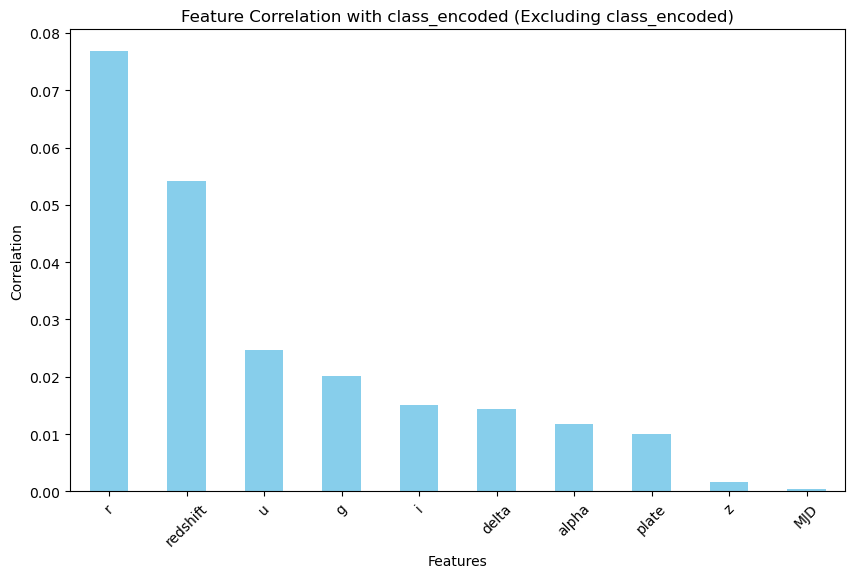

In [172]:
# Calculate the absolute correlation coefficients between features and the label column
correlations = df.corr()['class_encoded'].abs()

# Sort the features based on their correlation with the label column in descending order
sorted_features = correlations.sort_values(ascending=False)

sorted_features_without_target = sorted_features.drop('class_encoded', errors='ignore')

plt.figure(figsize=(10, 6))
sorted_features_without_target.plot(kind='bar', color='skyblue')
plt.title('Feature Correlation with class_encoded (Excluding class_encoded)')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()

In [173]:
df = df[['r','redshift','u','g','i','delta','alpha','plate','class_encoded']]
df.head()

,r,redshift,u,g,i,delta,alpha,plate,class_encoded
0,20.39501,0.634794,23.87882,22.27530,19.16573,32.494632,135.689107,5812,0
1,22.58444,0.779136,24.77759,22.83188,21.16812,31.274185,144.826101,10445,0
2,20.60976,0.644195,25.26307,22.66389,19.34857,35.582444,142.188790,4576,0
3,21.61162,0.932346,22.13682,23.77656,20.50454,-0.402828,338.741038,9149,0
4,16.49747,0.116123,19.43718,17.58028,15.97711,21.183866,345.282593,6121,0


### Boxplot for detecting anomaly

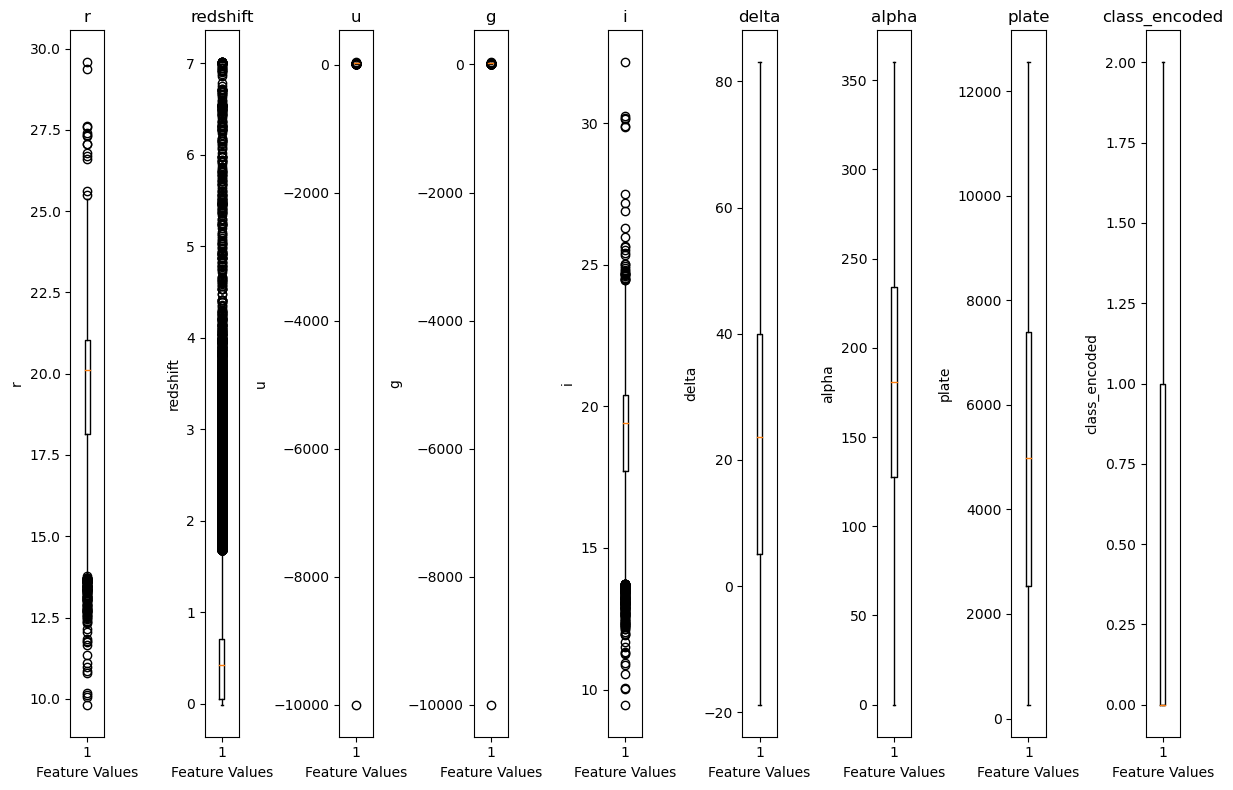

In [174]:
numerical_features = df.select_dtypes(include=['number'])

# Plot boxplots for each numerical feature individually
plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_features.columns):
    plt.subplot(1, len(numerical_features.columns), i + 1)
    plt.boxplot(numerical_features[column], sym='o')
    plt.title(column)
    plt.xlabel('Feature Values')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

#### Anomaly -Isolation forest

In [175]:
# Adjust contamination based on the expected ratio of anomalies
model = IsolationForest(contamination=0.05)  
model.fit(data)
anomalies = model.predict(data) == -1

anomalous_data = data[anomalies]

df = df[~anomalies]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   r              95000 non-null  float64
 1   redshift       95000 non-null  float64
 2   u              95000 non-null  float64
 3   g              95000 non-null  float64
 4   i              95000 non-null  float64
 5   delta          95000 non-null  float64
 6   alpha          95000 non-null  float64
 7   plate          95000 non-null  int64  
 8   class_encoded  95000 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 7.2 MB


In [177]:
y = df['class_encoded']
X = df.drop('class_encoded', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)

In [178]:
standard_scaler = StandardScaler()

stellar_data = standard_scaler.fit_transform(df)

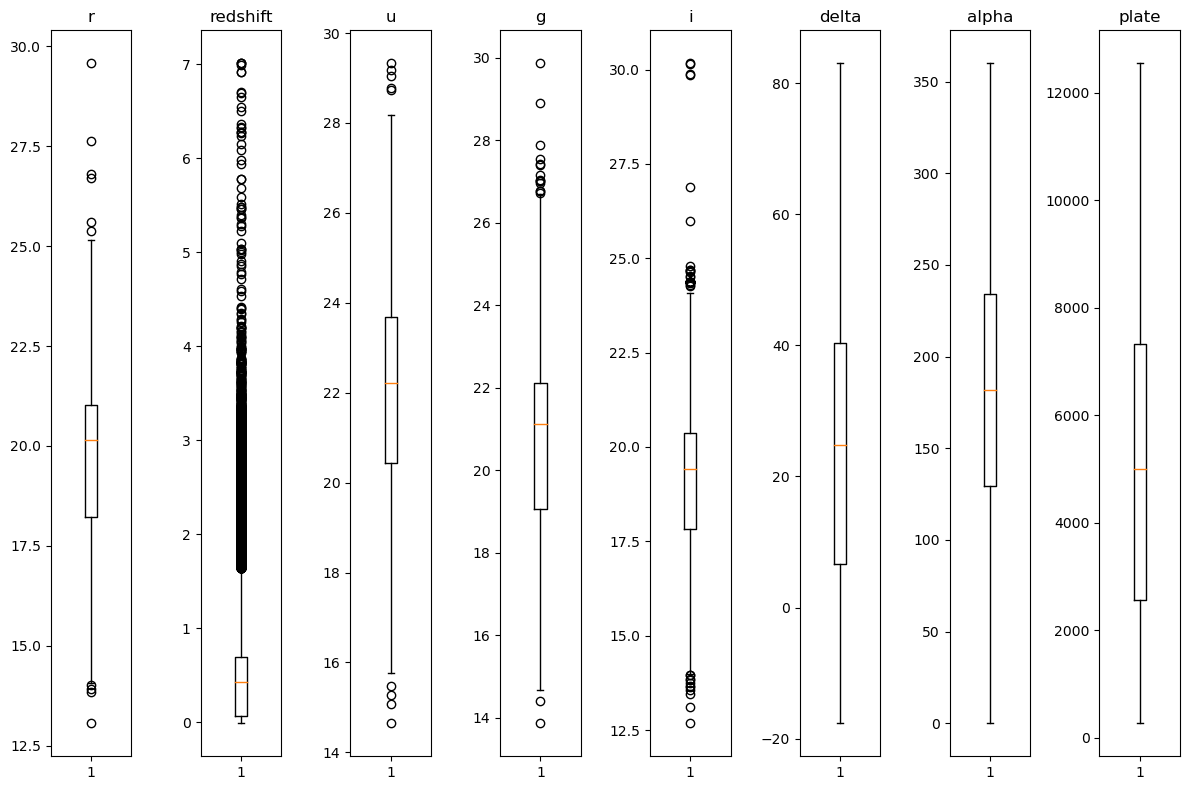

In [179]:
numerical_features = X_train.select_dtypes(include=['number'])

plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_features.columns):
    plt.subplot(1, len(numerical_features.columns), i + 1)
    plt.boxplot(numerical_features[column], sym='o')
    plt.title(column)

plt.tight_layout()
plt.show()

In [127]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances from the trained model
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
# Sort the features based on their importance values in descending order
sorted_feature_importances = feature_importances.sort_values(ascending=False)

print(sorted_feature_importances)

redshift    0.626452
i           0.097159
u           0.078886
g           0.067056
plate       0.056876
r           0.045685
delta       0.014633
alpha       0.013254
dtype: float64


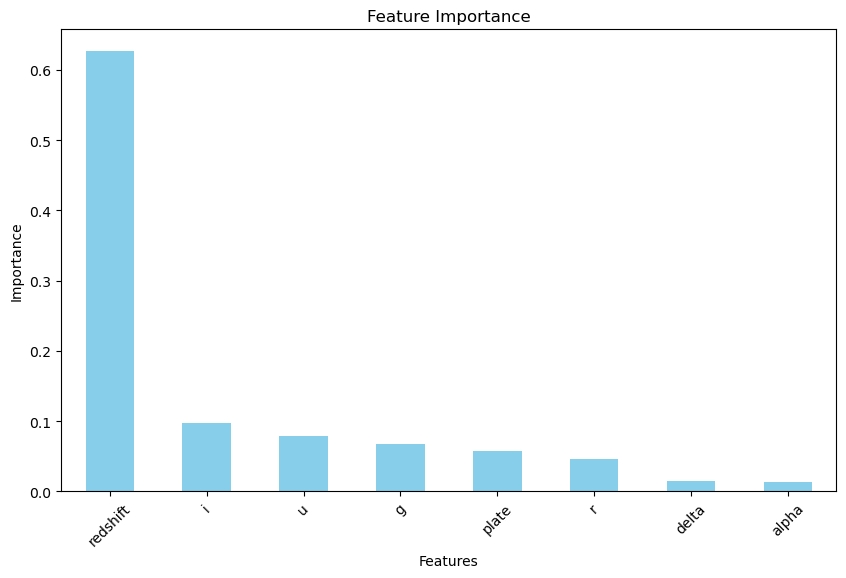

In [128]:
plt.figure(figsize=(10, 6))
sorted_feature_importances.plot(kind='bar', color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

/home/pilot/miniconda3/envs/jupyter/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pilot/miniconda3/envs/jupyter/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pilot/miniconda3/envs/jupyter/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


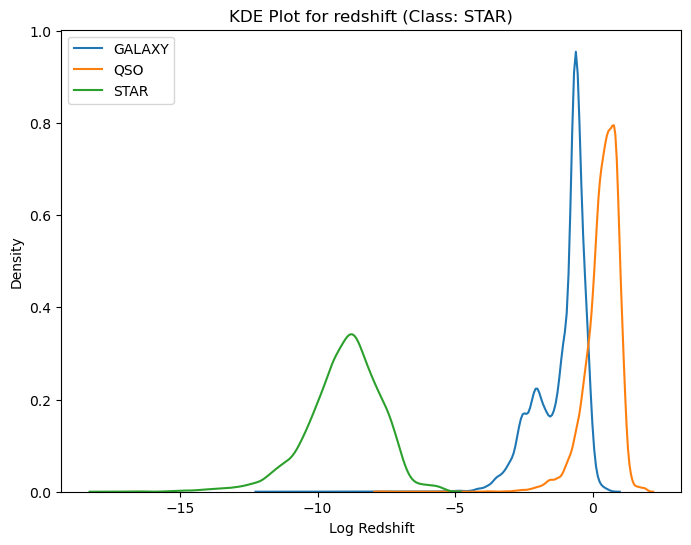

In [181]:
Classes = ['GALAXY', 'QSO', 'STAR']

plt.figure(figsize=(8, 6))

# Iterate through each class and plot KDE for the specified column 
for i, class_label in enumerate(Classes):
    sns.kdeplot(data=np.log(df[df["class_encoded"] == i]['redshift']),
                label=class_label)
    
plt.title(f'KDE Plot for redshift (Class: {class_label})')
plt.xlabel('Log Redshift')
plt.ylabel('Density')
plt.legend()
plt.show()

In [182]:
results = []

# Loop through different numbers of neighbors
for i in range(1, 31):
    model = KNeighborsClassifier(n_neighbors=i)
    
    cross_val_scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_accuracy = np.mean(cross_val_scores)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results.append({'Neighbors': i, 'Mean CV Accuracy': mean_accuracy, 'Test Accuracy': accuracy})

output_df = pd.DataFrame(results)

In [183]:
output_df

,Neighbors,Mean CV Accuracy,Test Accuracy
0,1,0.808515,0.819681
1,2,0.799042,0.812089
2,3,0.805939,0.822743
3,4,0.801241,0.811643
4,5,0.798319,0.810303
5,6,0.792710,0.805327
6,7,0.789112,0.803732
7,8,0.783975,0.798628
8,9,0.781744,0.795598
9,10,0.778146,0.793333


In [184]:
sorted_output_df = output_df.sort_values(by='Mean CV Accuracy', ascending=False)

print(sorted_output_df)

    Neighbors  Mean CV Accuracy  Test Accuracy
0           1          0.808515       0.819681
2           3          0.805939       0.822743
3           4          0.801241       0.811643
1           2          0.799042       0.812089
4           5          0.798319       0.810303
5           6          0.792710       0.805327
6           7          0.789112       0.803732
7           8          0.783975       0.798628
8           9          0.781744       0.795598
9          10          0.778146       0.793333
10         11          0.775035       0.789442
11         12          0.772192       0.787496
12         13          0.769788       0.784466
13         14          0.767023       0.781754
14         15          0.765090       0.779330
15         16          0.764242       0.777002
16         17          0.762231       0.775407
17         18          0.760047       0.773907
18         19          0.758743       0.772217
19         20          0.757093       0.771069
20         21

### Highest accuracy was for k=1, so training the classifier only for k=1

In [185]:
k = 1

model = KNeighborsClassifier(n_neighbors=k)

cross_val_scores = cross_val_score(model, X_train, y_train, cv=5)

print(f'Cross-Validation Accuracy Scores (k={k}): {cross_val_scores}')

mean_accuracy = np.mean(cross_val_scores)
std_accuracy = np.std(cross_val_scores)
print(f'Mean Accuracy: {mean_accuracy:.2f}')
print(f'Standard Deviation: {std_accuracy:.2f}')

Cross-Validation Accuracy Scores (k=1): [0.81013354 0.80793401 0.80974077 0.80683425 0.80793401]
Mean Accuracy: 0.81
Standard Deviation: 0.00


### KNN with weighted distance

In [186]:
model = KNeighborsClassifier(n_neighbors=5, weights='distance')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.83


In [187]:
report = classification_report(y_test, y_pred)
print( report)

              precision    recall  f1-score   support

           0       0.84      0.94      0.88     18965
           1       0.79      0.71      0.75      5712
           2       0.82      0.60      0.69      6673

    accuracy                           0.83     31350
   macro avg       0.81      0.75      0.77     31350
weighted avg       0.82      0.83      0.82     31350

